In [19]:
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression,  Lasso 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform
import warnings

warnings.filterwarnings('ignore')



# Exploration

In [20]:
df = pd.read_csv('flight.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [21]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [22]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [23]:
df.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [24]:
df['source_city'].value_counts()

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

In [25]:
df['departure_time'].value_counts()

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [26]:
df['stops'].value_counts()


stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

In [27]:
df['arrival_time'].value_counts()


arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64

In [28]:
df['destination_city'].value_counts()

destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

In [29]:
df['duration'].min()

np.float64(0.83)

In [30]:
df['duration'].max()

np.float64(49.83)

In [31]:
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

# Preprocessing

In [32]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('flight', axis=1) 
df['class'] = df['class'].apply(lambda x: 1 if x =='Business' else 0)


In [33]:
df.loc[:, 'periot_time_flight'] = df['departure_time'] + " to " + df['arrival_time']
df.loc[:, 'route'] = df['source_city'] + " to " + df['destination_city']

In [34]:
df.stops = pd.factorize(df.stops)[0]


In [35]:
if 'airline' in df.columns:
    df = df.join(pd.get_dummies(df['airline'], prefix='airline'))
    df = df.drop('airline', axis=1)


if 'source_city' in df.columns:
    df = df.join(pd.get_dummies(df['source_city'], prefix='source'))
    df = df.drop('source_city', axis=1)

if 'destination_city' in df.columns:
    df = df.join(pd.get_dummies(df['destination_city'], prefix='destination'))
    df = df.drop('destination_city', axis=1)

if 'arrival_time' in df.columns:
    df = df.join(pd.get_dummies(df['arrival_time'], prefix='arrival'))
    df = df.drop('arrival_time', axis=1)

if 'departure_time' in df.columns:
    df = df.join(pd.get_dummies(df['departure_time'], prefix='departure'))
    df = df.drop('departure_time', axis=1)
    
if 'stops' in df.columns:
    df = df.join(pd.get_dummies(df['stops'], prefix='stops'))
    df = df.drop('stops', axis=1)
    
if 'periot_time_flight' in df.columns:
    df = df.join(pd.get_dummies(df['periot_time_flight'], prefix='periot_time_flight'))
    df = df.drop('periot_time_flight', axis=1)
    
if 'route' in df.columns:
    df = df.join(pd.get_dummies(df['route'], prefix='route'))
    df = df.drop('route', axis=1)
    

In [36]:
df

,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,...,route_Kolkata to Bangalore,route_Kolkata to Chennai,route_Kolkata to Delhi,route_Kolkata to Hyderabad,route_Kolkata to Mumbai,route_Mumbai to Bangalore,route_Mumbai to Chennai,route_Mumbai to Delhi,route_Mumbai to Hyderabad,route_Mumbai to Kolkata
0,0,2.17,1,5953,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,2.33,1,5953,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2.17,1,5956,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,2.25,1,5955,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0,2.33,1,5955,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,1,10.08,49,69265,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
300149,1,10.42,49,77105,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
300150,1,13.83,49,79099,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
300151,1,10.00,49,81585,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## Linear Regression

In [37]:
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df['price'], test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred= model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(np.sqrt(mse), r2)

6670.347003029248 0.913685627184081


### Hyperparameter Tuning

In [39]:
param_grid = {
    'fit_intercept': [True, False]
}
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=2, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

y_pred = best_tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(np.sqrt(mse), r2)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ................................fit_intercept=False; total time=   4.1s
[CV] END .................................fit_intercept=True; total time=   4.1s
[CV] END ................................fit_intercept=False; total time=   4.2s
[CV] END ................................fit_intercept=False; total time=   4.2s
[CV] END .................................fit_intercept=True; total time=   4.2s
[CV] END .................................fit_intercept=True; total time=   4.2s
6670.347003029248 0.913685627184081


## Tree Regresion 

In [40]:
tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [41]:
y_pred = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(np.sqrt(mse), r2)

3468.869164932939 0.9766567079016834


### Hyperparameter Tuning

In [42]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': [1.0, 'auto', 'sqrt']
}



grid_search = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, n_iter=5, cv=5, scoring='neg_mean_squared_error', verbose=2, random_state=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

y_pred = best_tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(np.sqrt(mse), r2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10; total time=   0.0s
[CV] END max_dept

## Forest Regresion

In [43]:
forest_regression = RandomForestRegressor(n_jobs=-1)

forest_regression.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1)

In [44]:
y_pred = forest_regression.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(np.sqrt(mse), r2)

2787.662464765569 0.9849246765292996


### Hyperparameter Tuning

In [45]:
param_grid = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': [1.0, 'auto', 'sqrt']
}



grid_search = RandomizedSearchCV(estimator=forest_regression, param_distributions=param_grid, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

y_pred = best_tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(np.sqrt(mse), r2)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=213; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=213; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=213; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140; total time=  21.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140; total time=  21.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140; total time=  21.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time= 1.4min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200;

## Xgboost

In [46]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=20, learning_rate=0.1)
xgboost_model.fit(X_train, y_train)

 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
y_pred = xgboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(np.sqrt(mse), r2)

2582.967936604294 0.9870573282241821


In [48]:
param_grid = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 6, 10, 15, 20, 30],  
    'min_child_weight': randint(1, 10),  
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [1, 1.5, 2, 3]  
}



grid_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_grid, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

y_pred = best_tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(np.sqrt(mse), r2)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=223, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   7.9s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=223, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   8.0s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=223, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   8.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=140, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   8.3s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=140, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   8.4s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, m

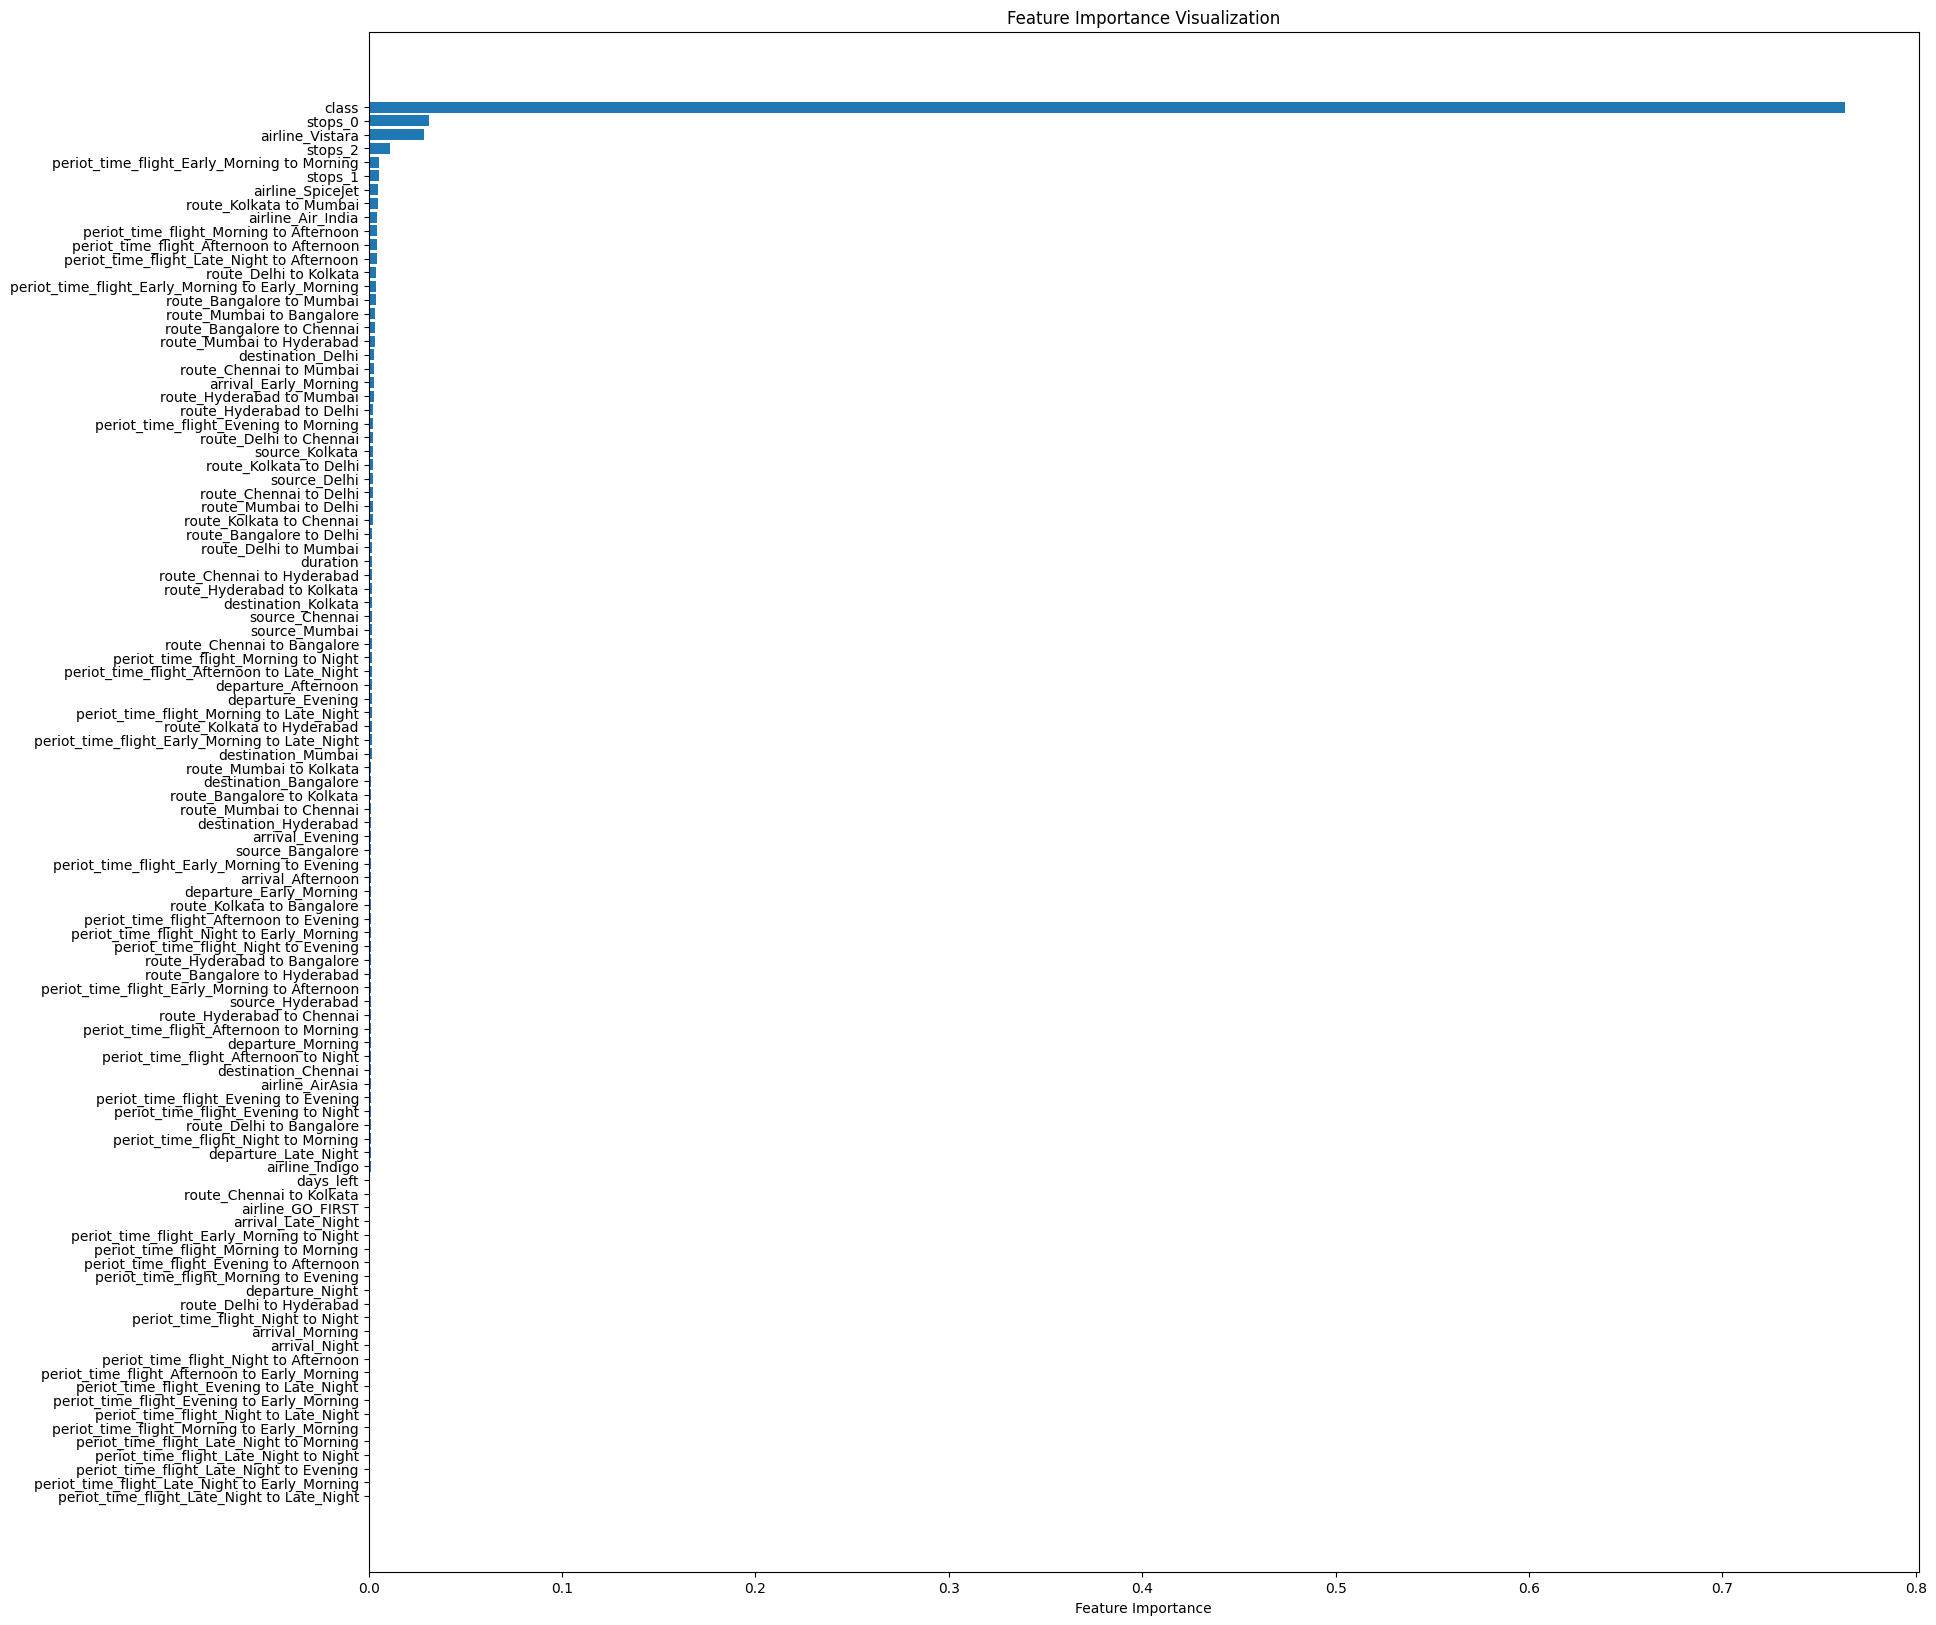

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract feature importance
feature_importances = best_tree_model.feature_importances_

# Step 2: Create a bar chart for visualization
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(20, 20))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Visualization')
plt.show()


Before applying feature engineering, several machine learning models were evaluated on the raw data. These models include linear regression, decision tree, random forests, and XGBOOST. The performance of these models was assessed using metrics such as RMSE (Root Mean Square Error) and R² (coefficient of determination).

Linear Regression:
RMSE: 6670.35
R²: 0.91

Decision Tree:
RMSE: 3468.87
R²: 0.98

Random Forests:
RMSE: 2787.66
R²: 0.98

XGBOOST:
RMSE: 2582.96
R²: 0.98

Based on these results, it is evident that more complex models like random forests and XGBOOST achieved better performance compared to simpler models like linear regression. The best performance before applying feature engineering was achieved by the XGBOOST model.